## **Taller 2** ##

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior.

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.


In [72]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as py
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Configuración de gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general (usa seaborn con fondo limpio)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk', font_scale=1.2)

# Configuración global de Matplotlib
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.titlesize': 18,
    'axes.titleweight': 'bold',
    'axes.titlepad': 15,
    'axes.labelsize': 13,
    'axes.labelcolor': 'black',
    'axes.edgecolor': 'gray',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.color': '#cccccc',
    'lines.linewidth': 2,  # grosor de las líneas
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'legend.frameon': False,
    'legend.fontsize': 12,
    'legend.loc': 'upper right',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.prop_cycle': plt.cycler(color=[
        '#007acc', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'
    ])  # paleta de colores corporativa
})

# Tema de seaborn adicional
sns.set_style("whitegrid")

In [4]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [5]:
data.shape

(222, 4)

El numero de ocupados crece en 19.7162 por mes, hay una tendencia creciente y sostenida, tiene un R-squared = 0.956, es alto, significa que el más del 05% de la variabilidad de los ocupados se puede explicar por el paso del tiempo.
Al probar los residuos co Durbin-Watson = 0.484, valor bajo, indica autocorrelación positiva fuerte entre los residuos, no son aleatorios --no ruido blanco (se está trazando una linea, así que se espera ese resultado).

De entrada se sabe que además de la tendencia creciente, hay un componente estacional, que la regresión simple no es suficiente.

Antes de continuar, para hacer pruebas del modelo, se hace la división de los datos en train y test, para poder hacer pruebas de MRSE

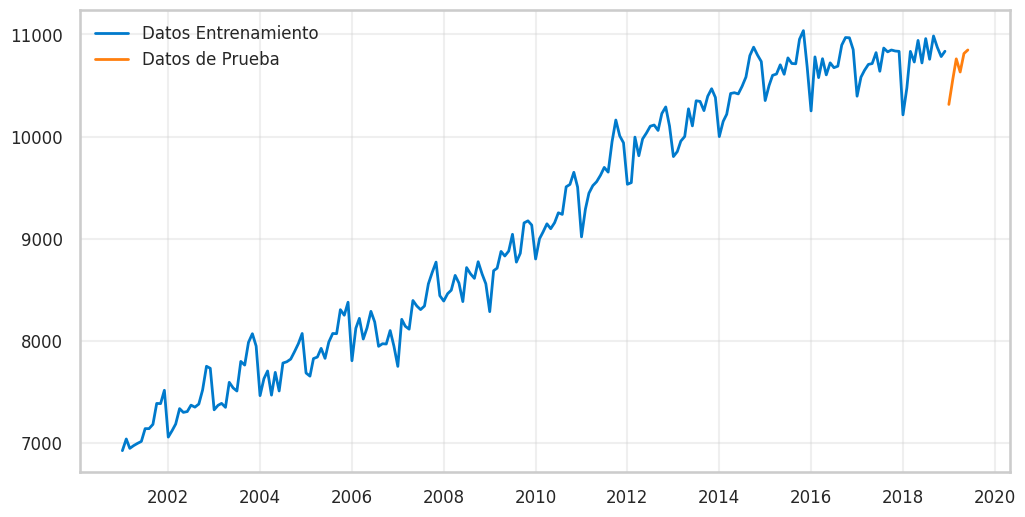

In [6]:
train_len = 216
train_to = data[["Ocupados"]][:train_len]
test_to = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_to,label="Datos Entrenamiento")
plt.plot(test_to,label="Datos de Prueba")
plt.legend(loc= "upper left")
plt.show()

## **Tendencia Lineal** ##

In [7]:
y = train_to["Ocupados"] ##Establecer la variable dependiente
x = np.linspace(1,train_len,train_len) ##Crear variable independiente con los meses de entrenamiento
X = sm.add_constant(x) ##Añadir constante al modelo
lin = sm.OLS(y,X) ##Definir el modelo de regresión lineal
lin_t = lin.fit() ##Ajustar el modelo
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     5386.
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          1.10e-153
Time:                        14:43:16   Log-Likelihood:                -1500.2
No. Observations:                 216   AIC:                             3004.
Df Residuals:                     214   BIC:                             3011.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6925.6150     34.477    200.879      0.0

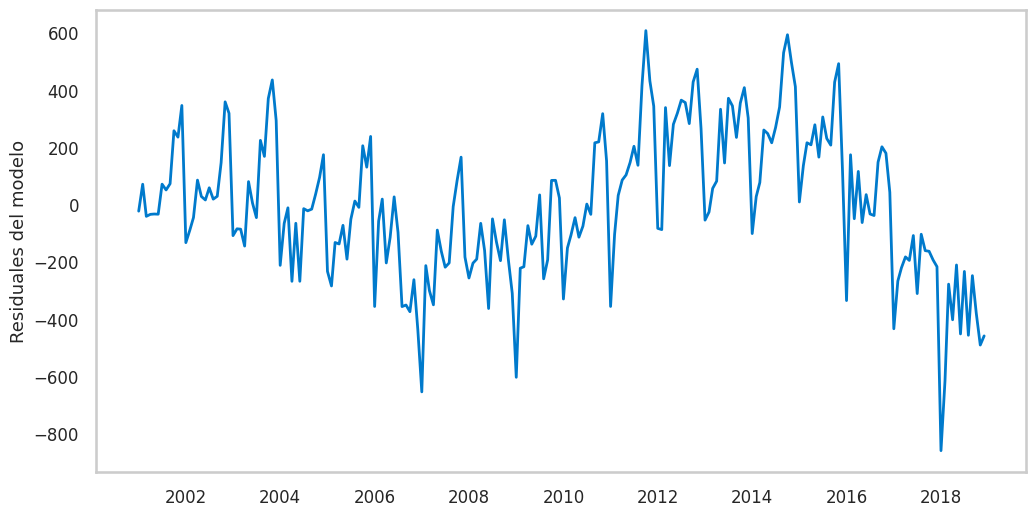

In [8]:
plt.ylabel("Residuales del modelo")
plt.plot(lin_t.resid)
plt.grid()

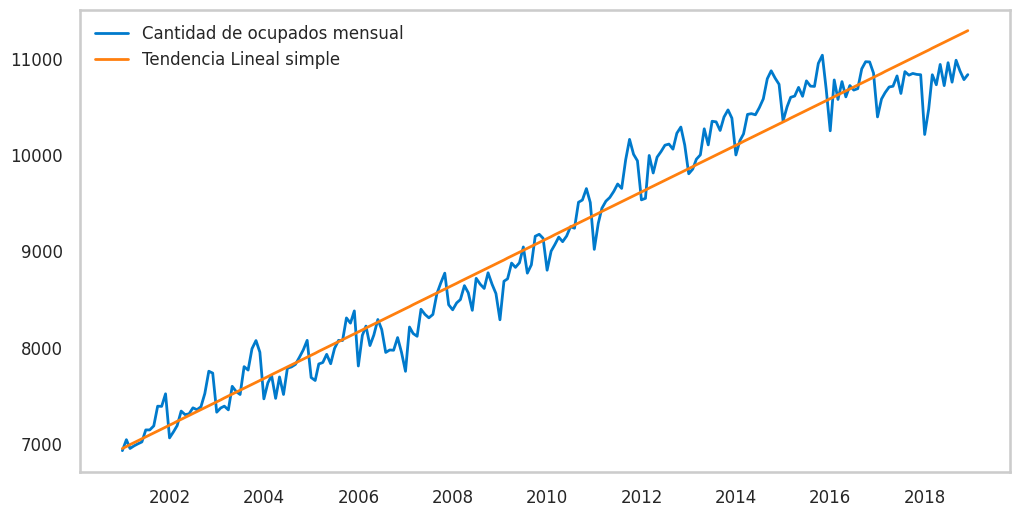

In [9]:
plt.plot(y,label="Cantidad de ocupados mensual")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal simple")
plt.legend(loc= "upper left")
plt.grid()
plt.show()

In [10]:
h=6 #Coloco 6 porque el horizonte de predicción es de 6 meses (test)
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
X_for= sm.add_constant(x_for)

In [11]:
dt = lin_t.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

   Point_forecast      lower_95      upper_95
0    11434.429742  10931.769830  11937.089654
1    11454.648642  10951.921266  11957.376018
2    11474.867542  10972.072125  11977.662959
3    11495.086442  10992.222407  11997.950478
4    11515.305342  11012.372112  12018.238573
5    11535.524243  11032.521240  12038.527245


In [12]:
# Fechas de pronóstico
future_dates = pd.date_range(
    train_to.index[-1] + pd.offsets.MonthBegin(1),  # mes siguiente al último
    periods=h,
    freq='MS'
)


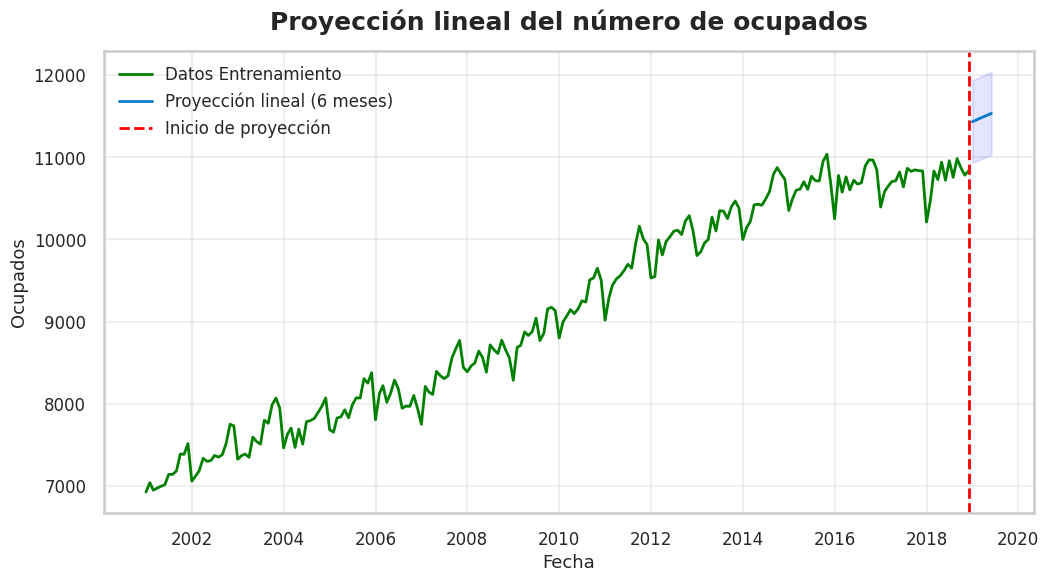

In [13]:
plt.figure(figsize=(12,6))
plt.plot(train_to.index, train_to["Ocupados"], label="Datos Entrenamiento", color="green")
plt.plot(future_dates, preds['Point_forecast'], label="Proyección lineal (6 meses)")

# Línea de inicio de proyección (en fecha, no en índice numérico)
plt.axvline(train_to.index[-1], color='red', linestyle='--', label='Inicio de proyección')


# Intervalos de confianza
plt.fill_between(future_dates, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend(loc="upper left")
plt.title("Proyección lineal del número de ocupados")
plt.xlabel("Fecha")
plt.ylabel("Ocupados")
plt.grid(alpha=0.3)
plt.show()

In [14]:
rmse = np.sqrt(mean_squared_error(test_to, y_prd))
print("RMSE del modelo lineal:", round(rmse, 2))

RMSE del modelo lineal: 844.51


### **Tendencia Cuadratica**

In [15]:
y = train_to["Ocupados"]
train_to["x"] = np.linspace(1, train_len, train_len)
train_to["x2"] = train_to["x"] ** 2
X = sm.add_constant(train_to[["x", "x2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     2752.
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          6.85e-153
Time:                        14:43:42   Log-Likelihood:                -1497.5
No. Observations:                 216   AIC:                             3001.
Df Residuals:                     213   BIC:                             3011.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6835.5053     51.482    132.774      0.0

En este modelo, se observa un x de 22.7, que significa que por cada mes aumentan en 22.7 personas los ocupados, el r2 nuevamente muestra que hay una tendencia positiva, incluso mejora el resultado anterior, con 96%, hay una tendencia cuadrática en el modelo.
Sin embargo el p de 0.569, nos muestra que no es estadisticamente significativo, el Durbin-Watson: 0.569, continua con autocorrelción positiva en los residuos (estos modelos aún no aplican estacionalidad)

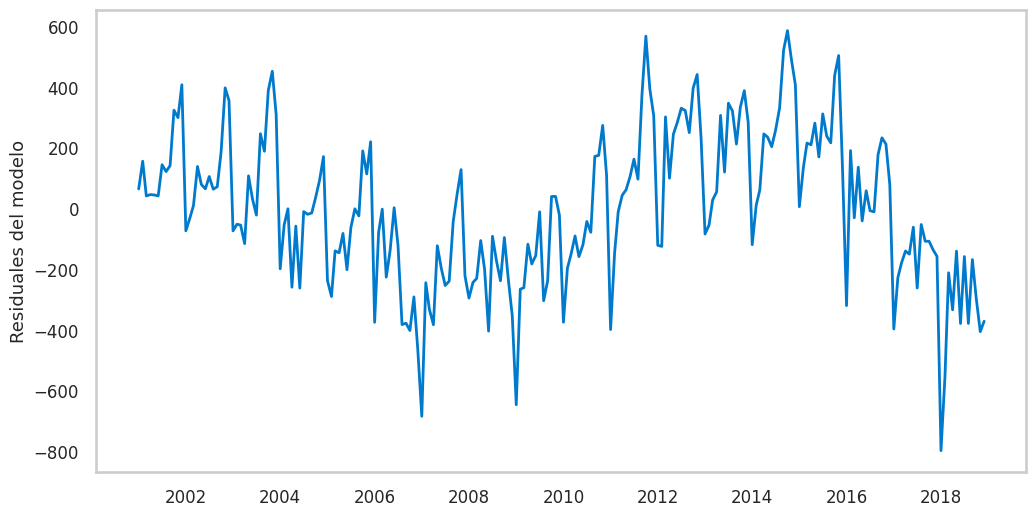

In [16]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_2.resid)
plt.grid()

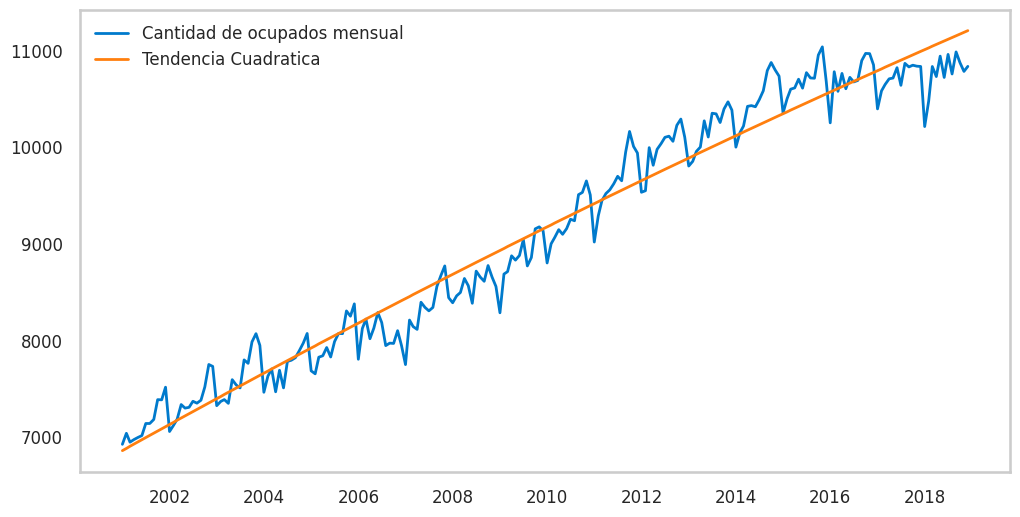

In [17]:
plt.plot(y,label="Cantidad de ocupados mensual")
plt.plot(pol_2.fittedvalues,label="Tendencia Cuadratica")
plt.legend(loc= "upper left")
plt.grid()
plt.show()

In [18]:
h = 6
x_for = np.linspace(train_to.shape[0] + 1, train_to.shape[0] + h, h)
X_for = sm.add_constant(np.stack((x_for, x_for**2), axis=1))

In [19]:
dt = pol_2.get_prediction(X_for).summary_frame(alpha=0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame({
    'Point_forecast': y_prd,
    'lower_95': yprd_ci_lower,
    'upper_95': yprd_ci_upper
})

print(preds)

   Point_forecast      lower_95      upper_95
0    11223.006575  10720.110033  11725.903118
1    11240.733961  10737.453096  11744.014826
2    11258.438489  10754.761188  11762.115790
3    11276.120159  10772.034093  11780.206225
4    11293.778971  10789.271596  11798.286346
5    11311.414925  10806.473482  11816.356368


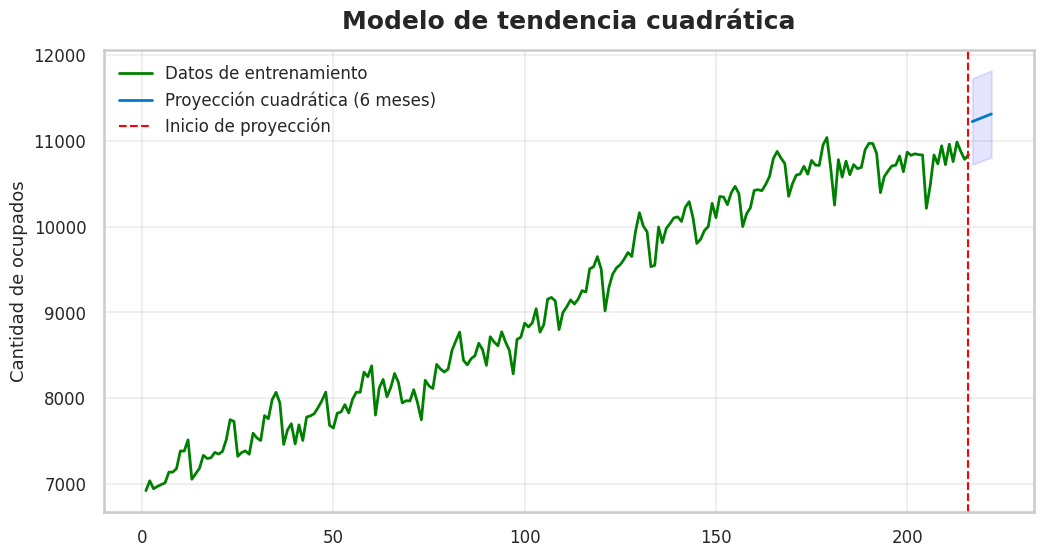

In [20]:
fig = plt.figure(figsize=(12, 6))

# Eje X numérico para entrenamiento
x = np.arange(1, train_to.shape[0] + 1)
y = train_to["Ocupados"].values

# Serie real (entrenamiento)
plt.plot(x, y, label="Datos de entrenamiento", color="green")

# Predicción futura
x_future = np.arange(train_to.shape[0] + 1, train_to.shape[0] + 1 + len(preds))
plt.plot(x_future,preds['Point_forecast'],label="Proyección cuadrática (6 meses)")

# Intervalo de confianza
plt.fill_between(x_future,preds['lower_95'],preds['upper_95'],color='blue',alpha=0.1)

# Línea divisoria del inicio de proyección
plt.axvline(x=train_to.shape[0], color='red',linestyle='--',linewidth=1.5,label='Inicio de proyección')

# Detalles del gráfico
plt.title("Modelo de tendencia cuadrática")
plt.ylabel("Cantidad de ocupados")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()


In [21]:
rmse_quad = np.sqrt(mean_squared_error(test_to["Ocupados"], y_prd))
print("RMSE del modelo de tendencia cuadrática:", round(rmse_quad, 2))

RMSE del modelo de tendencia cuadrática: 632.48


## **Revisión de la tendencia de manera polinómica** ##

In [22]:
# Variables
y_train = train_to["Ocupados"]
y_test = test_to["Ocupados"]

# Crear variable de tiempo para ambos conjuntos
train_to["x"] = np.linspace(1, train_to.shape[0], train_to.shape[0])
test_to["x"] = np.linspace(train_to.shape[0]+1, train_to.shape[0]+test_to.shape[0], test_to.shape[0])

# Rango de grados polinómicos a probar
grados = [2, 3, 4, 5, 6, 7, 8, 9, 10]

resultados = {}

for g in grados:
    # Crear variable x^g en ambos conjuntos
    train_to[f"x{g}"] = train_to["x"] ** g
    test_to[f"x{g}"] = test_to["x"] ** g

    # Definir las variables predictoras y añadir constante
    X_train = sm.add_constant(train_to[["x", f"x{g}"]])
    X_test = sm.add_constant(test_to[["x", f"x{g}"]])

    # Entrenar modelo en train
    modelo = sm.OLS(y_train, X_train).fit()

    # Predecir sobre test
    y_pred_test = modelo.predict(X_test)

    # Calcular RMSE en test
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Guardar resultados
    resultados[g] = {
        "R² (train)": round(modelo.rsquared_adj, 4),
        "RMSE (test)": round(rmse, 2)
    }

# Mostrar tabla resumen
tabla_resultados = pd.DataFrame(resultados).T
tabla_resultados.index.name = "Grado del polinomio"
print(tabla_resultados)



                     R² (train)  RMSE (test)
Grado del polinomio                         
2                        0.9624       632.48
3                        0.9640       546.52
4                        0.9657       461.49
5                        0.9672       384.85
6                        0.9685       320.02
7                       -4.3530      3699.44
8                      -35.7405     12022.38
9                      -37.0772     12541.37
10                     -38.1932     13040.06


Pareciera que el mejor modelo, el que mejor captura la tendencia es el del grado 6, sin embargo, podría haber overfitting y pierde interpretabilidad

## **Estacionalidad** ##

A partir de acá, el objetivo es capturar la estacionalidad de los modelos, inicialmente generando un numero por cad mes desde el índice de fechas

In [23]:
# Asegurar índice datetime y frecuencia mensual, para crear dummies de meses
train_to.index = pd.to_datetime(train_to.index)
train_to = train_to.asfreq('MS')

In [24]:
# Crear las dummies mensuales (todas numéricas)
month_dummies = pd.get_dummies(train_to.index.month, prefix='mes', drop_first=True)
month_dummies.index = train_to.index
# Convertir a float explícitamente ( evita el error de casteo)
month_dummies = month_dummies.astype(float)

In [25]:
train_to.index.month.value_counts()

,count
mes,
1,18
2,18
3,18
4,18
5,18
6,18
7,18
8,18
9,18


In [26]:
# Definir las variables
y = train_to["Ocupados"].astype(float)
X = sm.add_constant(month_dummies)

# Ajustar modelo OLS
sea = sm.OLS(y, X)
season = sea.fit()

# Resultado
print(season.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.3897
Date:                Sat, 08 Nov 2025   Prob (F-statistic):              0.959
Time:                        14:44:24   Log-Likelihood:                -1850.6
No. Observations:                 216   AIC:                             3725.
Df Residuals:                     204   BIC:                             3766.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8724.5387    308.558     28.275      0.0

In [27]:
month_dummies


,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
mes,,,,,,,,,,,
2001-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-02-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-03-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-04-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-05-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2018-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2018-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


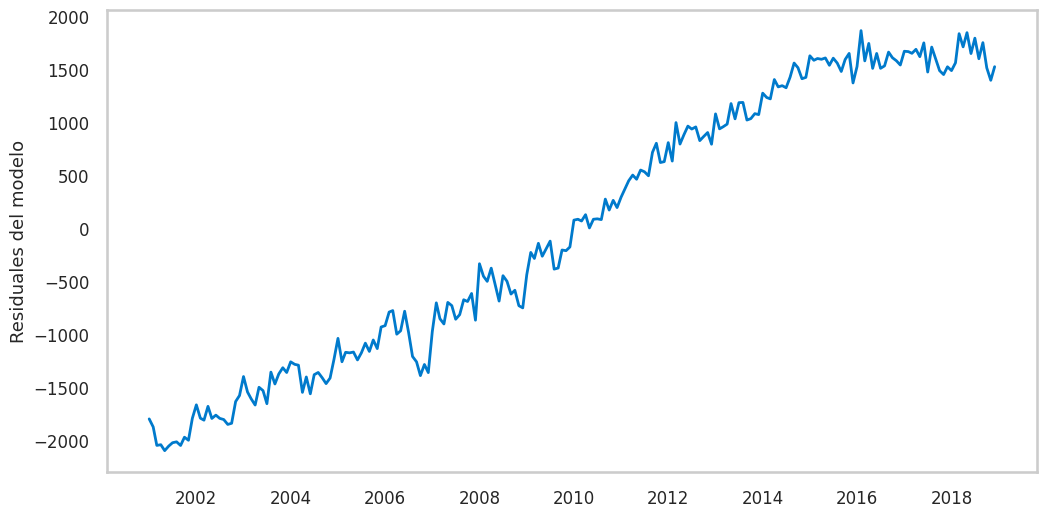

In [28]:
plt.ylabel("Residuales del modelo")
plt.plot(season.resid)
plt.grid()

El modelo con solo dummies mensuales para capturar la estacionalidad no es syficiente, subestima en los primeros años y sobreestima en los finales
El componente estacional existe pero no es suficiente.
hay que agregar un término que capture la tendencia de largo plazo.

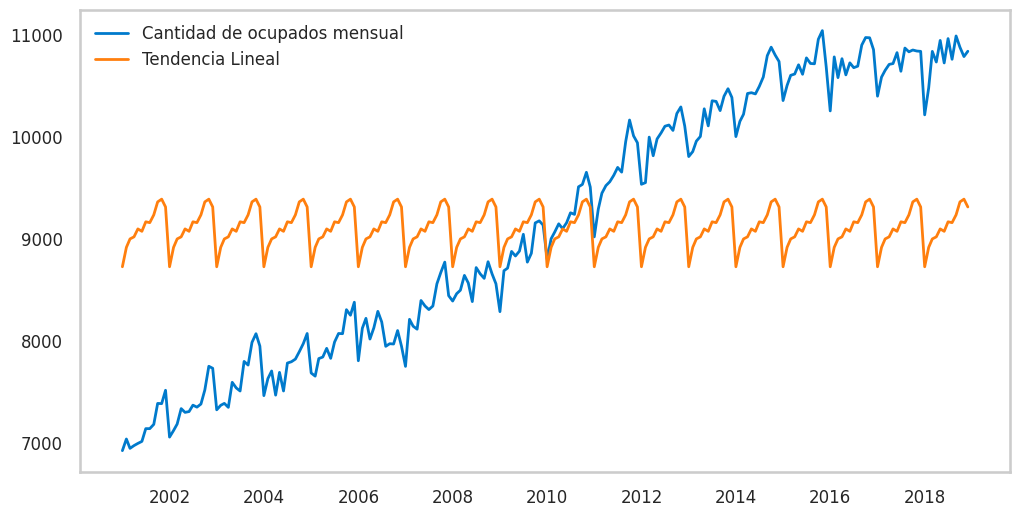

In [29]:
plt.plot(y,label="Cantidad de ocupados mensual")
plt.plot(season.fittedvalues,label="Tendencia Lineal")
plt.legend(loc= "upper left")
plt.grid()
plt.show()

In [30]:
range_dates = pd.date_range(train_to.index[-1]+ relativedelta(months=1), periods=12,freq='MS')

x_for = pd.get_dummies(range_dates.month,drop_first=True).astype(int)
X_for= sm.add_constant(x_for)

In [31]:
dt = season.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast     lower_95      upper_95
2019-01-01     8724.538722  6072.708767  11376.368678
2019-02-01     8914.544389  6262.714433  11566.374344
2019-03-01     8997.218333  6345.388378  11649.048289
2019-04-01     9017.681722  6365.851767  11669.511678
2019-05-01     9095.089000  6443.259045  11746.918955
2019-06-01     9071.789000  6419.959045  11723.618955
2019-07-01     9164.935167  6513.105211  11816.765122
2019-08-01     9156.633500  6504.803545  11808.463455
2019-09-01     9232.988500  6581.158545  11884.818455
2019-10-01     9359.934944  6708.104989  12011.764900
2019-11-01     9386.702222  6734.872267  12038.532178
2019-12-01     9310.332667  6658.502711  11962.162622


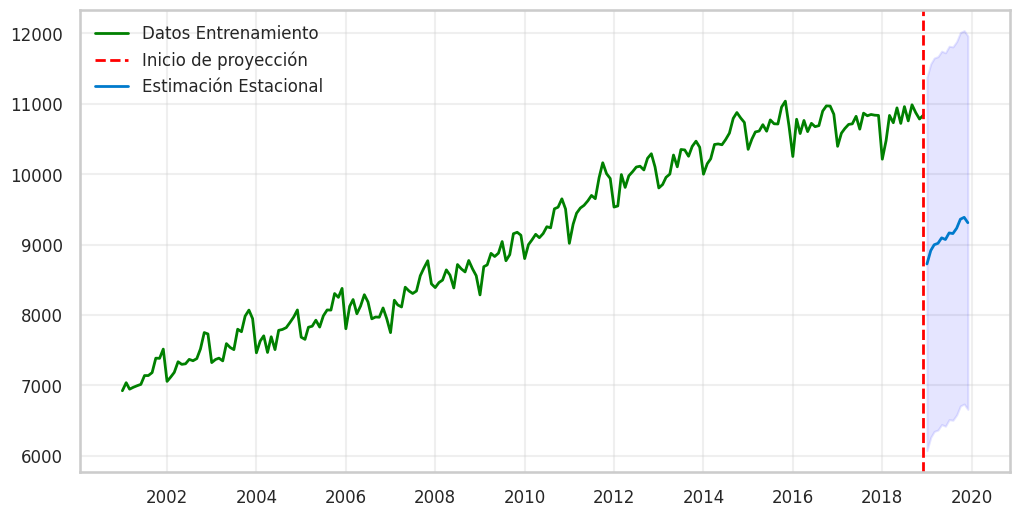

In [32]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_to.index, train_to["Ocupados"], label="Datos Entrenamiento", color="green")
plt.axvline(train_to.index[-1], color='red', linestyle='--', label='Inicio de proyección')
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend(loc= "upper left")
plt.show()

In [33]:
# Predicciones dentro del conjunto de entrenamiento
dt_train = season.get_prediction().summary_frame(alpha=0.05)
y_pred_train = dt_train['mean']

# Cálculo del RMSE (comparando con los valores reales)
rmse = np.sqrt(mean_squared_error(train_to["Ocupados"], y_pred_train))

print(f"RMSE del modelo lineal estacional: {rmse:.2f}")

RMSE del modelo lineal estacional: 1272.22


### **Tendencia + Estacionalidad**

In [34]:
y = train_to["Ocupados"]
train_to["x"] = np.linspace(1,train_to.shape[0],train_to.shape[0])
train_to["x6"] = train_to["x"]**6

month_dummies = pd.get_dummies(train_to.index.month,drop_first=True).set_index(train_to.index).astype(int)
X = sm.add_constant( pd.concat([train_to[["x","x6"]],month_dummies],axis=1) )

season_pol6 = sm.OLS(y,X)
season_pol6 = season_pol6.fit()
print(season_pol6.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     753.2
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          4.54e-161
Time:                        14:44:46   Log-Likelihood:                -1440.4
No. Observations:                 216   AIC:                             2907.
Df Residuals:                     203   BIC:                             2951.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6510.3377     54.047    120.457      0.0

Este modelo sí se ajusta mejor, tiene un r2 de 97.8%, lo cual es muy bueno, con un crecimiento segun e lmodelo de 20 por mes, ell componente cuadrático no aporta mucho.

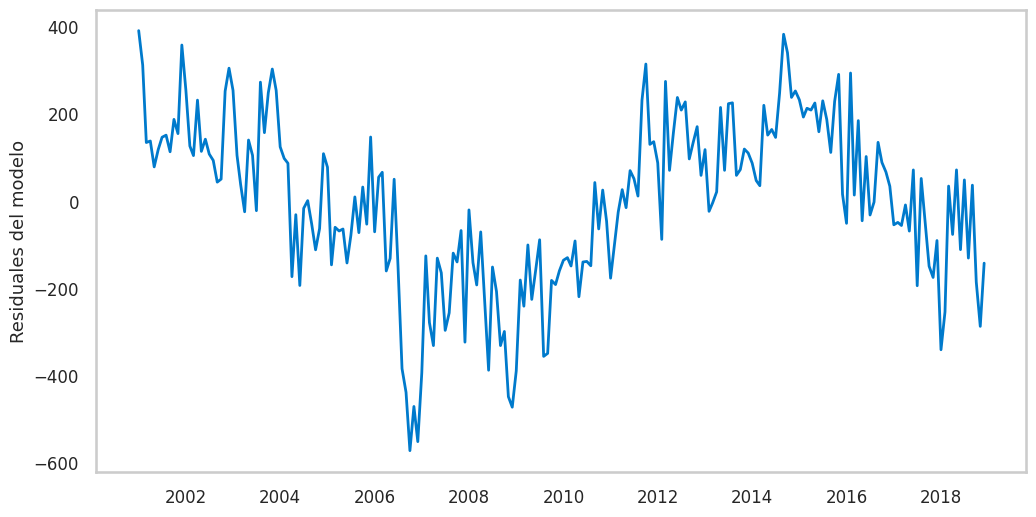

In [35]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol6.resid)
plt.grid()

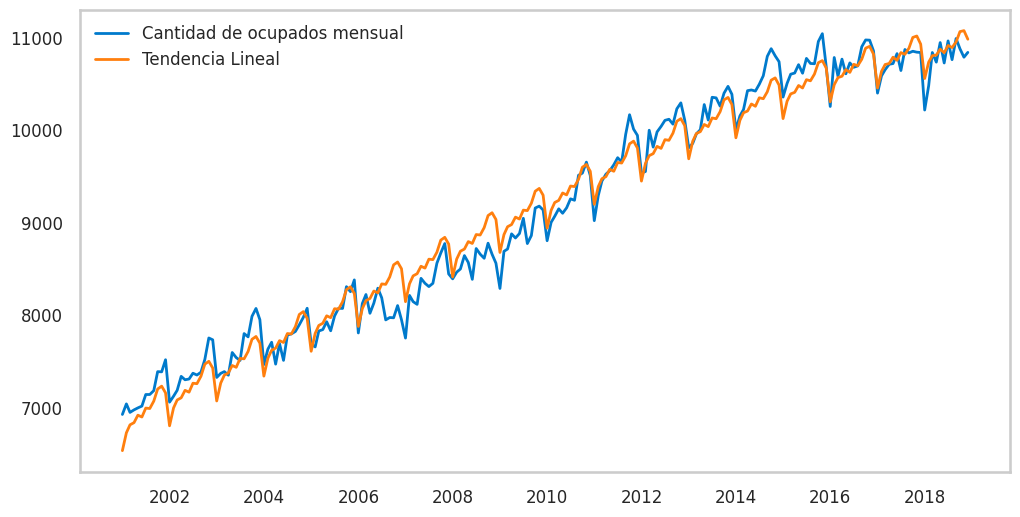

In [36]:
plt.plot(y,label="Cantidad de ocupados mensual")
plt.plot(season_pol6.fittedvalues,label="Tendencia Lineal")
plt.legend(loc="upper left")
plt.grid()
plt.show()

In [37]:
h=12
x_for= np.linspace((train_to.shape[0]+1),(train_to.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**6),axis=1),columns=["x","x6"] )

range_dates = pd.date_range(train_to.index[-1]+ relativedelta(months=1), periods=h,freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True)

X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1))
X_for

,const,x,x6,2,3,4,5,6,7,8,9,10,11,12
0,1.0,217.0,1.044139e+14,False,False,False,False,False,False,False,False,False,False,False
1,1.0,218.0,1.073344e+14,True,False,False,False,False,False,False,False,False,False,False
2,1.0,219.0,1.103227e+14,False,True,False,False,False,False,False,False,False,False,False
3,1.0,220.0,1.133799e+14,False,False,True,False,False,False,False,False,False,False,False
4,1.0,221.0,1.165074e+14,False,False,False,True,False,False,False,False,False,False,False
5,1.0,222.0,1.197065e+14,False,False,False,False,True,False,False,False,False,False,False
6,1.0,223.0,1.229785e+14,False,False,False,False,False,True,False,False,False,False,False
7,1.0,224.0,1.263247e+14,False,False,False,False,False,False,True,False,False,False,False
8,1.0,225.0,1.297463e+14,False,False,False,False,False,False,False,True,False,False,False
9,1.0,226.0,1.332449e+14,False,False,False,False,False,False,False,False,True,False,False


In [39]:
dt = season_pol6.get_prediction(X_for.astype(int)).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
preds = preds.iloc[:6]
print(preds)

            Point_forecast      lower_95      upper_95
2019-01-01    10600.876719  10187.851969  11013.901469
2019-02-01    10772.557837  10358.477046  11186.638629
2019-03-01    10836.498843  10421.294543  11251.703144
2019-04-01    10837.813824  10421.415652  11254.211996
2019-05-01    10895.650057  10477.984595  11313.315520
2019-06-01    10852.349122  10433.339817  11271.358427


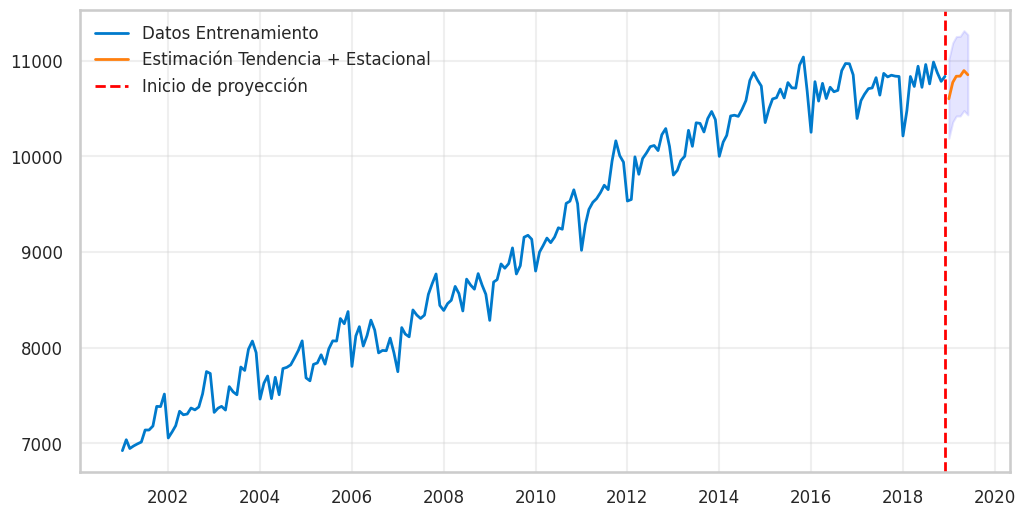

In [40]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.axvline(train_to.index[-1], color='red', linestyle='--', label='Inicio de proyección')
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend(loc="upper left")
plt.show()

In [42]:
y_true = train_to["Ocupados"]
y_pred = season_pol6.fittedvalues

# cálculo del RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"RMSE del modelo tendencia + estacionalidad: {rmse:.2f}")

RMSE del modelo tendencia + estacionalidad: 190.53


### **Comparación de modelos**

Para realizar la comparación de los modelos se debe usar una metrica de desempeño, en la clase anterior usamos el RMSE, la comparación se debe hacer fuera de muestra.
A continuación se muestra tabla con los datos obtenidos de los ejercicios anteriores, dado que de este ejercicio se obtiene como mejor métrica el modelo con tendencia y estacionaidad, es el que se usará para la predicción de los 6 meses siguientes

| Modelo                                      | Descripción                                    |     RMSE    | Interpretación                                                                                     |
| :------------------------------------------ | :--------------------------------------------- | :---------: | :------------------------------------------------------------------------------------------------- |
| **Lineal simple**                           | Tendencia lineal sin estacionalidad            |  **844.51** | Captura la tendencia general, pero deja mucha variabilidad sin explicar.                           |
| **Tendencia cuadrática**                    | Tendencia con término ( x^2 )                  |  **632.48** | Mejora considerablemente la precisión al permitir curvatura en la tendencia.                       |
| **Lineal estacional**                       | Solo estacionalidad (sin tendencia)            | **1272.22** | La estacionalidad por sí sola no explica bien el comportamiento global.                            |
| **Tendencia + estacionalidad (grado 6)** | Modelo completo con tendencia y estacionalidad |  **190.53** | Es el modelo más preciso: combina tendencia y estacionalidad, ajustando mejor los patrones reales. |


## **Proyección de 6 meses siguientes** ##

In [44]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x6"] = data["x"]**6

month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index).astype(int)
X = sm.add_constant( pd.concat([data[["x","x6"]],month_dummies],axis=1) )

season_pol6 = sm.OLS(y,X)
season_pol6 = season_pol6.fit()
print(season_pol6.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     792.7
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          5.84e-167
Time:                        14:47:09   Log-Likelihood:                -1479.3
No. Observations:                 222   AIC:                             2985.
Df Residuals:                     209   BIC:                             3029.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6492.7844     52.398    123.912      0.0

In [45]:
h=12
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**6),axis=1),columns=["x","x6"] )

range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=h,freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True)

X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1))
X_for

,const,x,x6,2,3,4,5,6,7,8,9,10,11,12
0,1.0,223.0,1.229785e+14,False,False,False,False,False,True,False,False,False,False,False
1,1.0,224.0,1.263247e+14,False,False,False,False,False,False,True,False,False,False,False
2,1.0,225.0,1.297463e+14,False,False,False,False,False,False,False,True,False,False,False
3,1.0,226.0,1.332449e+14,False,False,False,False,False,False,False,False,True,False,False
4,1.0,227.0,1.368218e+14,False,False,False,False,False,False,False,False,False,True,False
5,1.0,228.0,1.404782e+14,False,False,False,False,False,False,False,False,False,False,True
6,1.0,229.0,1.442158e+14,False,False,False,False,False,False,False,False,False,False,False
7,1.0,230.0,1.480359e+14,True,False,False,False,False,False,False,False,False,False,False
8,1.0,231.0,1.519399e+14,False,True,False,False,False,False,False,False,False,False,False
9,1.0,232.0,1.559294e+14,False,False,True,False,False,False,False,False,False,False,False


In [48]:
dt = season_pol6.get_prediction(X_for.astype(int)).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
preds = preds.iloc[:6]
print(preds)



            Point_forecast      lower_95      upper_95
2019-07-01    10869.865360  10459.776835  11279.953885
2019-08-01    10838.853517  10427.766407  11249.940627
2019-09-01    10892.006563  10479.859437  11304.153688
2019-10-01    10995.251000  10581.979789  11408.522210
2019-11-01    10997.807841  10583.345770  11412.269912
2019-12-01    10896.710945  10480.988463  11312.433427


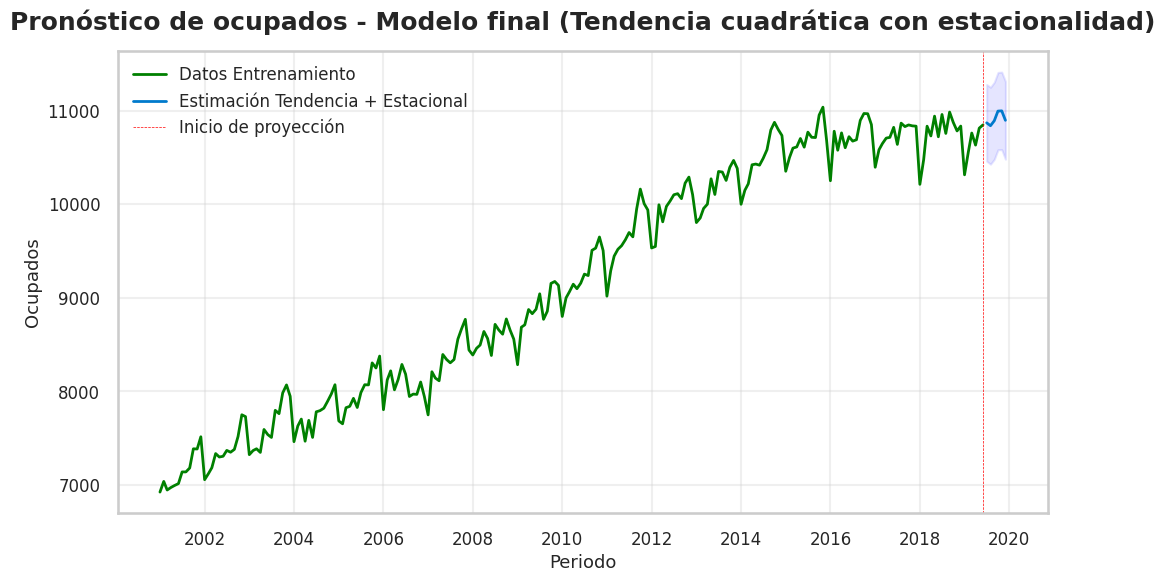

In [49]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento", color="green")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.axvline(data.index[-1], color='red', linestyle='--', label='Inicio de proyección', linewidth=0.5)
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.title("Pronóstico de ocupados - Modelo final (Tendencia cuadrática con estacionalidad)")
plt.xlabel("Periodo")
plt.ylabel("Ocupados")
plt.legend(loc="upper left")
plt.show()

## **Validación de supuestos** ##

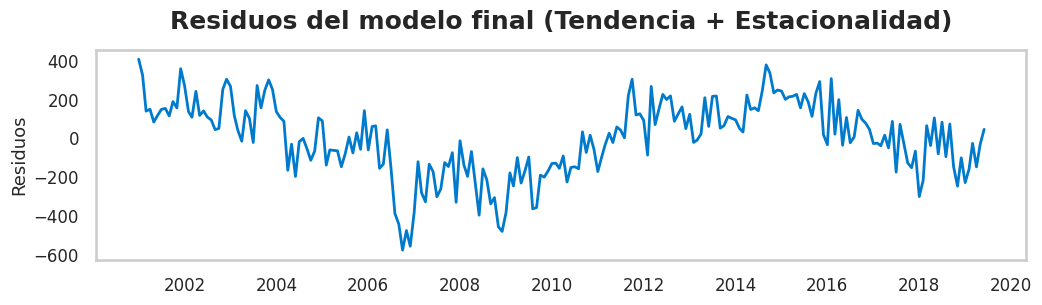

In [51]:
# Graficando los residuos del modelo final
fig = plt.figure(figsize=(12, 6))

plt.subplot(2,1, 1)
plt.title("Residuos del modelo final (Tendencia + Estacionalidad)")
plt.ylabel("Residuos")
plt.plot(season_pol6.resid)
plt.grid()

## Autocorrelación

Para determinar si existe autocorrelación vamos a usar la prueba de Ljung-Box. Esta prueba evalúa si los residuos están correlacionados entre sí:

𝐻₀: No hay autocorrelación (ρ = 0)  
𝐻₁: Hay autocorrelación (ρ ≠ 0)

Rechazo H₀ cuando el p-valor es menor al nivel de significancia α = 0.05.

In [ ]:
signo = season_pol_3.resid>0

In [53]:
# Prueba simple de autocorrelación usando Ljung-Box
lb_test = sm.stats.acorr_ljungbox(season_pol6.resid, lags=1, return_df=True)
print("Prueba de Ljung-Box para autocorrelación:")
print(f"Estadístico: {lb_test.iloc[0]['lb_stat']:.4f}")
print(f"P-valor: {lb_test.iloc[0]['lb_pvalue']:.2e}")
if lb_test.iloc[0]['lb_pvalue'] < 0.05:
    print("Conclusión: Hay autocorrelación en los residuos")
else:
    print("Conclusión: No hay autocorrelación en los residuos")

Prueba de Ljung-Box para autocorrelación:
Estadístico: 132.2973
P-valor: 1.29e-30
Conclusión: Hay autocorrelación en los residuos


### Interpretación de la prueba de Ljung-Box:

El p-valor obtenido es muy pequeño (< 0.05), por lo tanto se rechaza H₀.

**Conclusión:** Los residuos **SÍ presentan autocorrelación**, lo que indica que el modelo no está capturando completamente la estructura temporal de los datos.

In [55]:
Resul_lb_bp = sm.stats.acorr_ljungbox(season_pol6.resid, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,132.297315,1.288086e-30,130.525476,3.144703e-30,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,249.527320,6.543814e-55,245.662088,4.520176e-54,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,357.323097,3.872187e-77,351.051709,8.829730e-76,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,445.141376,4.877456e-95,436.517713,3.567305e-93,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,522.547113,1.083513e-110,511.504521,2.623266e-108,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,596.552236,1.292549e-125,582.866603,1.156522e-122,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,664.252586,3.502169e-139,647.846850,1.201512e-135,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,727.950033,6.859727e-152,708.700661,9.581557e-148,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,795.976631,1.561705e-165,773.386667,1.135786e-160,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,857.342162,9.613078e-178,831.464759,3.539602e-172,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


## Homoscedasticidad y Heteroscedasticidad

𝐻0:  Comportamiento Homoscedastico (Es decir varianza constante)

𝐻1:  Comportamiento Heteroscedastico (Es decir varianza no constante)

Rechazo  𝐻0  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α =0.05 ( α  = nivel de significancia).

In [58]:
# Prueba de Heteroscedasticidad - Test de Ljung-Box en residuos al cuadrado
hetero_test = sm.stats.acorr_ljungbox((season_pol6.resid - season_pol6.resid.mean())**2,
                                      lags=range(1,21), return_df=True, boxpierce=True)
hetero_test["lb_decision"] = np.where(hetero_test['lb_pvalue']<0.05, 'Rechaza H0: Hay Heteroscedasticidad', 'No rechaza H0: Homoscedasticidad')
hetero_test[["lb_stat", "lb_pvalue", "lb_decision"]].head(10)

,lb_stat,lb_pvalue,lb_decision
1,88.477596,5.141391e-21,Rechaza H0: Hay Heteroscedasticidad
2,128.852032,1.047459e-28,Rechaza H0: Hay Heteroscedasticidad
3,153.214103,5.337981e-33,Rechaza H0: Hay Heteroscedasticidad
4,160.355098,1.226786e-33,Rechaza H0: Hay Heteroscedasticidad
5,162.557657,2.820805e-33,Rechaza H0: Hay Heteroscedasticidad
6,164.786112,5.733802e-33,Rechaza H0: Hay Heteroscedasticidad
7,165.235631,2.534115e-32,Rechaza H0: Hay Heteroscedasticidad
8,166.536235,6.857086e-32,Rechaza H0: Hay Heteroscedasticidad
9,167.919457,1.673483e-31,Rechaza H0: Hay Heteroscedasticidad
10,168.290016,6.267261e-31,Rechaza H0: Hay Heteroscedasticidad


### Interpretación de la prueba de Ljung-Box en residuos al cuadrado:

Si el p-valor < 0.05: Se rechaza H₀, hay evidencia de heteroscedasticidad.
Si el p-valor ≥ 0.05: No se rechaza H₀, se asume homoscedasticidad.

Vamos a agregar también la prueba de Breusch-Pagan:

In [61]:
# Prueba de Breusch-Pagan para heteroscedasticidad
from statsmodels.stats.diagnostic import het_breuschpagan

# Obtener las variables explicativas del modelo final
X_model = season_pol6.model.exog

# Realizar la prueba de Breusch-Pagan
bp_stat, bp_pvalue, f_stat, f_pvalue = het_breuschpagan(season_pol6.resid, X_model)

print("=== PRUEBA DE BREUSCH-PAGAN PARA HETEROSCEDASTICIDAD ===")
print(f"Estadístico BP: {bp_stat:.4f}")
print(f"P-valor: {bp_pvalue:.6f}")
print(f"Estadístico F: {f_stat:.4f}")
print(f"P-valor F: {f_pvalue:.6f}")
print()
if bp_pvalue < 0.05:
    print("Conclusión: Se rechaza H₀ - HAY HETEROSCEDASTICIDAD")
else:
    print("Conclusión: No se rechaza H₀ - HOMOSCEDASTICIDAD")

=== PRUEBA DE BREUSCH-PAGAN PARA HETEROSCEDASTICIDAD ===
Estadístico BP: 23.8555
P-valor: 0.032485
Estadístico F: 2.0969
P-valor F: 0.018399

Conclusión: Se rechaza H₀ - HAY HETEROSCEDASTICIDAD


## Normalidad

𝐻0: Normalidad

𝐻1: No normalidad

Rechazo 𝐻0 cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un α =0.05 ( α = nivel de significancia).

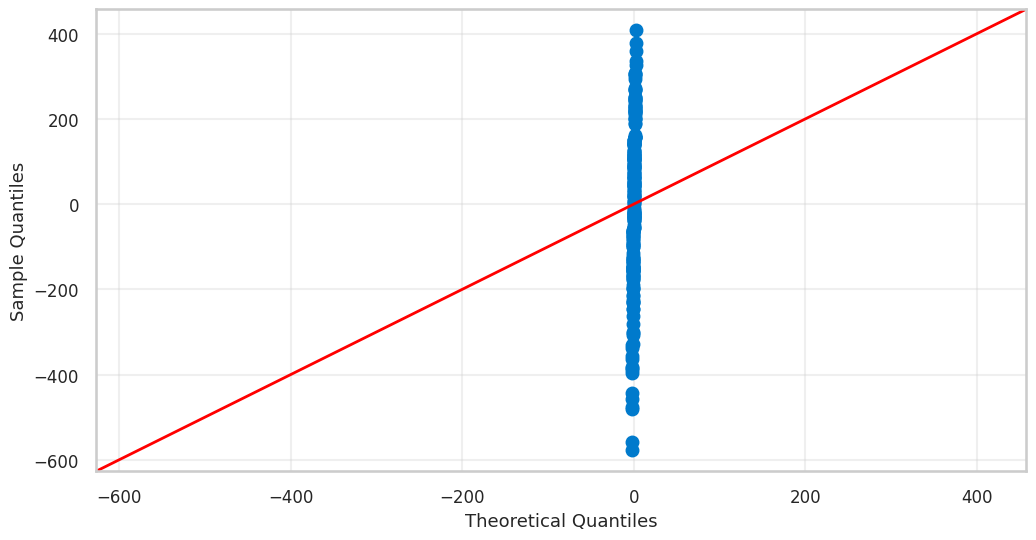

In [73]:
sm.qqplot(season_pol6.resid, line ='45')
py.show()

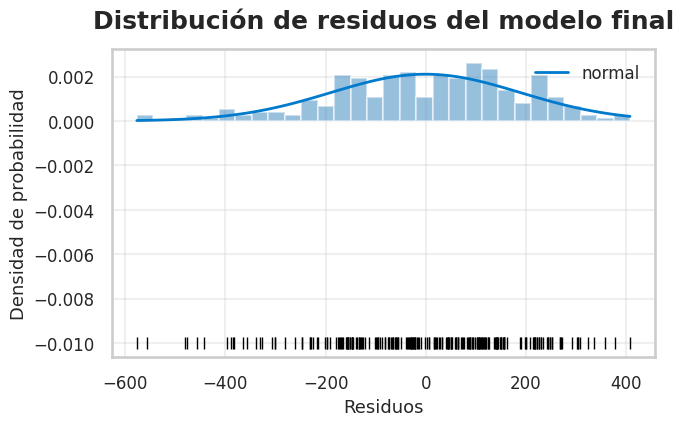

In [68]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(season_pol6.resid)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(season_pol6.resid), max(season_pol6.resid), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=season_pol6.resid, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(season_pol6.resid, np.full_like(season_pol6.resid, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución de residuos del modelo final')
ax.set_xlabel('Residuos')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

In [69]:
stats.shapiro(season_pol6.resid)

ShapiroResult(statistic=np.float64(0.9816680743958337), pvalue=np.float64(0.005579296156369587))

In [70]:
stats.jarque_bera(season_pol6.resid)

SignificanceResult(statistic=np.float64(8.505948146153687), pvalue=np.float64(0.014221874056839761))

### Interpretación de las pruebas de normalidad:

**Prueba de Shapiro-Wilk:** Si p-valor < 0.05, se rechaza H₀ (normalidad).
**Prueba de Jarque-Bera:** Si p-valor < 0.05, se rechaza H₀ (normalidad).

**Conclusión:** Para ambas pruebas, se puede rechazar la hipótesis nula de normalidad, indicando que los residuos NO siguen una distribución normal.

### Resultados de las pruebas realizadas sobre el modelo_

1. **AUTOCORRELACIÓN:**
   - Prueba de Ljung-Box: Se rechaza H₀ → **HAY autocorrelación** (p-valor = 1.29e-30)

2. **HETEROSCEDASTICIDAD:**
   - Ljung-Box en residuos²: Se rechaza H₀ → **HAY heteroscedasticidad** (p-valores < 0.05)
   - Breusch-Pagan: Se rechaza H₀ → **HAY heteroscedasticidad** (p-valor = 0.032)
   - **Conclusión consistente:** Ambas pruebas confirman heteroscedasticidad

3. **NORMALIDAD:**
   - Shapiro-Wilk: Se rechaza H₀ → **NO hay normalidad** (p-valor = 0.0056)
   - Jarque-Bera: Se rechaza H₀ → **NO hay normalidad** (p-valor = 0.014)
   - Q-Q Plot: Visual confirma desviación de la normalidad

### **CONCLUSIÓN GENERAL:**
El modelo final **NO CUMPLE** con los supuestos clásicos de regresión lineal:
- Los residuos presentan **autocorrelación** significativa
- Los residuos presentan **heteroscedasticidad** (confirmado por ambas pruebas)
- Los residuos **no siguen una distribución normal**

### **INTERPRETACIÓN:**
Aunque el modelo tiene buen ajuste (R² = 97%), las violaciones de supuestos implican:
- Los intervalos de confianza pueden no ser confiables
- Los errores estándar de los coeficientes pueden estar mal estimados
- Las pruebas de hipótesis pueden dar resultados incorrectos
